In [2]:
#import libraries
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

In [3]:
#clean up data
df=pd.read_csv("onlinefraud.csv",sep=',')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
print(df.dtypes)

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [5]:
for column in df.columns:
    if df[column].dtype == 'object':
        column_mode = df[column].mode()[0] #for categorical values we take the most frequent(cause mean doest exist for categorical) to replace NaN
        df[column].fillna(column_mode, inplace=True)
    else:
        column_avg = df[column].mean()#fnd mean of column and replace all NaN values with that mean
        df[column].fillna(column_avg, inplace=True)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
#Inbalance in dataset, to train effectively need to balance the data
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

As we can see above, we are currently working with a very imbalanced dataset. If we leave this as is, the training of these algorithms will be very biased towards one instance. This will lead to poor performance on test data and future data.

In [12]:
#Balance Data
np.random.seed(42)
df_majority = df[df.isFraud == 0]
df_minority = df[df.isFraud == 1]

df_majority_balance = df_majority.sample(n = 8213, replace = False)

df_balanced = pd.concat([df_minority, df_majority_balance])
df_balanced['isFraud'].value_counts()

1    8213
0    8213
Name: isFraud, dtype: int64

After using the above balancing technique, we now have a dataset of 16426 instances. This way we will have an even split of fraud and non-fraud instances during training.

In [13]:
#fit a decision tree
np.random.seed(42)
indpendent=['type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFlaggedFraud']
dependent='isFraud'
X=df_balanced[indpendent]
y=df_balanced[dependent]

X = pd.concat([X,pd.get_dummies(X['type'], prefix='type')],axis=1)
X.drop(['type'],axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

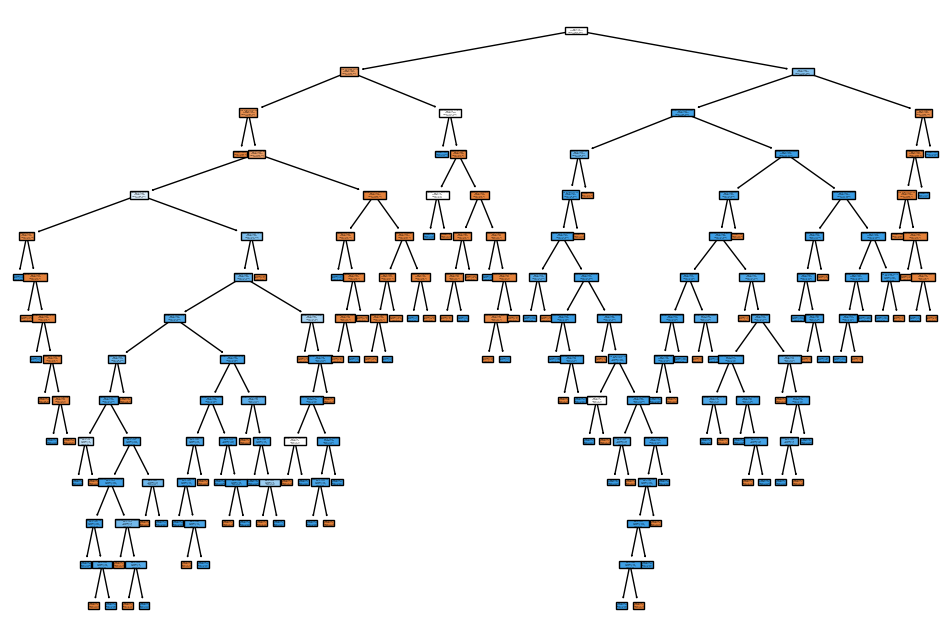

In [14]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=X_train.columns, class_names=['No', 'Yes'], filled=True)
plt.show()

Above we can see the full Decision Tree from the balanced dataset. This tree is very large and most likely overfitting the data. Because of this, we need to do some significant pruning in order to generalize the model.

9


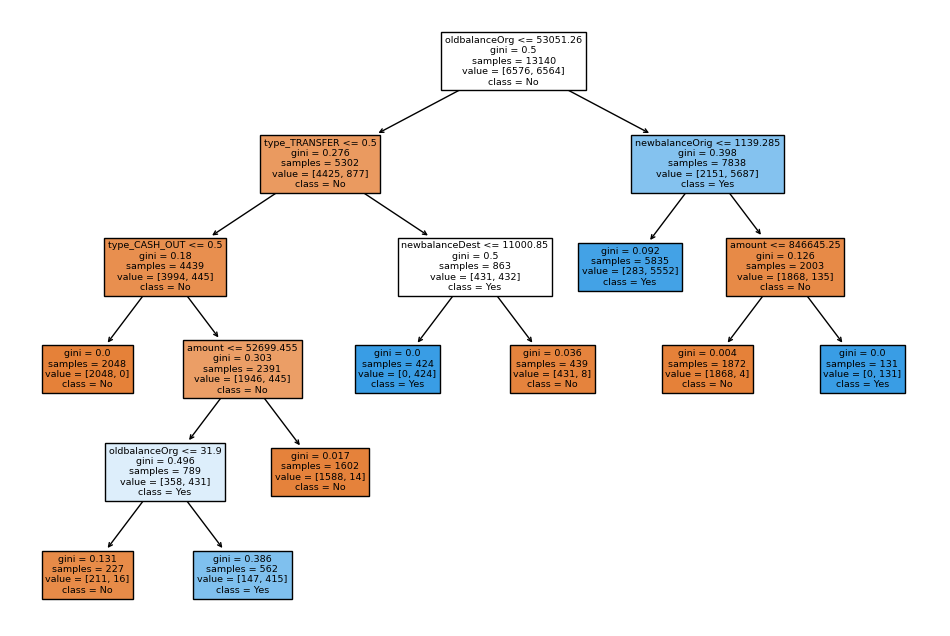

In [15]:
params = {'max_leaf_nodes': list(range(2, 10))}
grid_search_cv = GridSearchCV(model, params, cv=4)

grid_search_cv.fit(X_train, y_train)

best=grid_search_cv.best_params_['max_leaf_nodes']
print(best)

pruned_model = DecisionTreeClassifier(max_leaf_nodes=best)
pruned_model.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(pruned_model, feature_names=X_train.columns, class_names=['No', 'Yes'], filled=True)
plt.show()

We applied a grid search to test out different numbers of leaf nodes ranging from 2 to 20. This way we can prune the tree while still maintaining a high accuracy score. The result of the gridsearch shows that the best max leaf nodes is 19.

In [16]:
y_pred = pruned_model.predict(X_test).reshape(-1,1)

print("Accuracy: ", accuracy_score(y_pred, y_test))

Accuracy:  0.9646987218502739


As seen above, the accuracy of the pruned tree is quite high. The pruned tree is also much smaller and will be able to generalize to more data when applicable.

Artificial Neural Network

In [11]:
clf = MLPClassifier(hidden_layer_sizes = (5,2), activation = "tanh", 
                    solver = "adam", alpha = 1E-5, random_state = 42, max_iter = 200)

fraud = clf.fit(X_train, y_train)

Initialized an MLP Classifier with two hidden layers, one with 5 neurons and the other with 2. I used this approach because it is a binary classification task, which can be solved with just two layers in ANN algorithms. I also wanted to avoid using too many neurons, however because of the number of independent columns in the dataset we will have to add more.

In [12]:
y_pred = fraud.predict(X_test).reshape(-1,1)

print("Accuracy: ", accuracy_score(y_pred, y_test))

Accuracy:  0.8575776019476568


Accuracy score isn't bad, not as good as the Decision Tree. Below we apply another gridsearch to tune the hyperparameters of the MLP Classifier. Because it's a relatively simple task we decided to only test a couple of different sizes for the network. 

In [13]:
parameter_space = {
    'hidden_layer_sizes': [(10,10,10), (25,25)],
    'alpha': [0.0001, 0.05],
}

gsc = GridSearchCV(clf, parameter_space, n_jobs=-1, cv=3)
gsc.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MLPClassifier(activation='tanh', alpha=1e-05,
                                     hidden_layer_sizes=(5, 2),
                                     random_state=42),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 10, 10), (25, 25)]})

In [14]:
print("New Score: ", gsc.best_score_)
print("New Parameters: ", gsc.best_params_)

New Score:  0.9398782343987824
New Parameters:  {'alpha': 0.0001, 'hidden_layer_sizes': (25, 25)}


As you can see above, we can improve our model by using an alpha of 0.0001 and having two hidden layers each with 25 neurons. 

In [15]:
clf_best = MLPClassifier(hidden_layer_sizes = (25,25), activation = "tanh", 
                    solver = "adam", alpha = 0.0001, random_state = 42, max_iter = 200)

fraud_best = clf_best.fit(X_train, y_train)

In [16]:
y_pred_best = fraud_best.predict(X_test).reshape(-1,1)

print("Accuracy: ", accuracy_score(y_pred_best, y_test))

Accuracy:  0.9257455873402313


Out accuracy score increased a significant amount after changing it to the best parameters from the grid search. Aditionally we calculated the sample accuracies to show how well the ANN performed on predicting fraud and non-fraud cases respectively, which can be seen below:

In [17]:
fraud = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])
notFraud = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
print("Percent Fraud Correctly Predicted: ", fraud)
print("Percent Not Fraud Correctly Predicted: ", notFraud)

Percent Fraud Correctly Predicted:  0.8417222559126744
Percent Not Fraud Correctly Predicted:  0.8735491753207086


Ensemble: Logistic Regression, Random Forest, SVC

In [18]:
log_clf = LogisticRegression(solver="liblinear", random_state=42, max_iter = 500)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma = "auto", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

Here we are implementing our ensemble learning algorithm. We went with a Voting Classifier with three algorithms: Logistic Regression, Random Forest Classifier, and a Support Vector Machine Classifier.

In [19]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=500, random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc',
                              SVC(gamma='auto', probability=True,
                                  random_state=42))],
                 voting='soft')

In [20]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8122337188070603
RandomForestClassifier 0.9917833231892879
SVC 0.5103469263542301
VotingClassifier 0.9860012172854534


Above we can see the accuracies of each algorithm in the Voting Classifier as well as the accuracy for the Voting Classifier overall. The performance of Logistic Regression is pretty good, the performance of the Random Forest is great, and the performance of the SVC is poor. Because of the poor performance of the SVC, we attempted a grid search to test the different kernel functions and whether or not they improve the accuracy of the SVC. We tested the 'linear', 'poly', 'rbf', and 'sigmoid' kernel functions. Unfortunately, the runtime for fitting the grid search was taking days without a solutiion. Because of this, we decided to stick with the default 'rbf' function. Even though the SVC performed poorly, the Voting Classifier still performed the best of all three of our machine learning algorithms. This goes to show that when there's error in one part of the Voting Classifier, the other algorithms will complement the error.

In [21]:
fraudV = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])
notFraudV = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
print("Percent Fraud Correctly Predicted: ", fraudV)
print("Percent Not Fraud Correctly Predicted: ", notFraudV)

Percent Fraud Correctly Predicted:  0.992116434202547
Percent Not Fraud Correctly Predicted:  0.9798411728772144


As seen above, the sample accuracies are very high. This shows that the ensemble learning method performed extremely well on predicting fraud and non-fraud cases.